# MH 采样

## 连续数据

目标平稳分布是一个均值3，标准差2的正态分布，而选择的马尔可夫链状态转移矩阵Q(i,j)的条件转移概率是以i为均值,方差1的正态分布在位置j的值。这个例子仅仅用来让大家加深对M-H采样过程的理解。毕竟一个普通的一维正态分布用不着去用M-H采样来获得样本。

我们无法保证马尔科夫矩阵一开始就收敛，所以应该在收敛后再采集样本，但是这里面越过了 burn-in 的过程，直接进行采值。

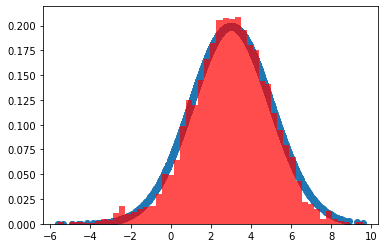

In [15]:
# 如果当u大于接受率的时候，这时候直接丢弃，相当于x(t+1)时刻没有采用任何值，接下来做的应该是再次重复算法。
# 直到某个u小于接受率，然后我们接受这个转移值

import random
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline


# norm_dist_prob 就是最终目标p(x) 的分布
def norm_dist_prob(theta):
    #求概率密度函数指定点（theta）的函数值，即theta点附近的可能性。
    y = norm.pdf(theta, loc=3, scale=2)
    return y

T = 5000
pi = [0 for i in range(T)]
sigma = 1
t = 0
while t < T-1:
    
    # pi_star可以认为是第j个状态，pi[t - 1]可以认为是第i个状态。
    t = t + 1
    
    # 生成服从均值是pi[t - 1]，标准差是1的正态分布的随机数。pi_star就是x_star。
    # 也就是说pi[t - 1]这个状态，以服从pi[t - 1]为均值,方差1的正态分布的概率转移到了pi_star状态。
    
    #location ( loc) 关键字指定平均值。scale ( scale) 关键字指定标准偏差。size 指定生成随机数个数
    # 这里是执行条件分布采样。采样基于的分布是均值为上一个值(t-1)，方差为给定值的正态分布
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    
    # 求alpha。使用的是二维对称的正态分布作为Q，所以是对称的Q(i,j)与Q(j,i)相同。
    # norm_dist_prob(pi_star)即pi_star状态在平稳分布中的概率。
    alpha = min(1, (norm_dist_prob(pi_star[0]) / norm_dist_prob(pi[t - 1]))) 

    u = random.uniform(0, 1)
    # 如果均匀采样的值小于alpha，那么就接受这个采样值pi_star。
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]


plt.scatter(pi, norm.pdf(pi, loc=3, scale=2))
num_bins = 50
plt.hist(pi, num_bins, density=1, facecolor='red', alpha=0.7)
plt.show()

In [17]:
pi[:30]

[0,
 -0.3195195766204326,
 -0.3195195766204326,
 -0.71174484205933,
 -1.1061111453162285,
 -1.1061111453162285,
 -1.1061111453162285,
 -2.3050765816707504,
 -3.149970273380977,
 -2.501582565548081,
 -2.501582565548081,
 -2.501582565548081,
 -2.513978896488897,
 -0.292618848380815,
 -0.04423829962689893,
 0.8868109913312797,
 0.8868109913312797,
 0.8868109913312797,
 0.8868109913312797,
 1.753405419383057,
 1.300962615564794,
 1.2439147132380388,
 0.8617365138793898,
 0.8617365138793898,
 0.8617365138793898,
 1.2846369863668152,
 2.878513063042062,
 2.1310730043622876,
 2.516711726118931,
 2.874658239222246]

### 为什么 Qi,j = Qj,i 


<div align=center><img " src="./static/code1.jpg"/></div>


## 离散数据

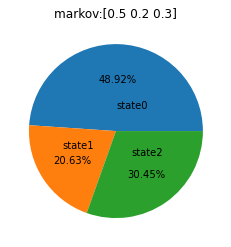

In [11]:
'''
Created on 2018年5月16日
p:输入的概率分布，离散情况采用元素为概率值的数组表示
N:认为迭代N次马尔可夫链收敛
Nlmax:马尔可夫链收敛后又取的服从p分布的样本数
isMH:是否采用MH算法，默认为True

1）输入我们任意选定的马尔科夫链状态转移矩阵Q，平稳分布π(x)，设定状态转移次数阈值n1，需要的样本个数n2
2）从任意简单概率分布采样得到初始状态值x0
3）for t=0 to n1+n2−1:
　a) 从条件概率分布Q(x|xt)中采样得到样本x∗
　b) 从均匀分布采样u∼uniform[0,1]
　c) 如果u<α(xt,x∗)=π(x∗)Q(x∗,xt), 则接受转移xt→x∗，即xt+1=x∗
　d) 否则不接受转移，即xt+1=xt
样本集(xn1,xn1+1,...,xn1+n2−1)即为我们需要的平稳分布对应的样本集。
'''

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from array import array
%matplotlib inline

def mcmc(Pi ,Q,N=1000,Nlmax=10000,isMH=True):
    X0 = np.random.randint(len(Pi))# 第一步：从均匀分布（随便什么分布都可以）采样得到初始状态值x0
    T = N+Nlmax-1
    result = [0 for i in range(T)]
    t = 0
    while t < T-1:
        t = t + 1
        # 从条件概率分布Q(x|xt)中采样得到样本x∗
        # 该步骤是模拟采样，根据多项分布，模拟走到了下一个状态
        #（也可以将该步转换成一个按多项分布比例的均匀分布来采样）  
        x_cur = np.argmax(np.random.multinomial(1,Q[result[t-1]]))  # 第二步：取下一个状态 ，采样候选样本
#         print('x_cur: ',x_cur)
#         print(Q[result[t-1]])
#         print(result[t-1])
#         break
        if isMH:
            '''
                细致平稳条件公式：πi Pij=πj Pji,∀i,j
            '''
            a = (Pi[x_cur] * Q[x_cur][result[t-1]]) /(Pi[result[t-1]] * Q[result[t-1]][x_cur])  # 第三步：计算接受率
            acc = min(a ,1)
        else: #mcmc
            acc = Pi[x_cur] * Q[x_cur][result[t-1]]
        u = np.random.uniform(0 ,1)  # 第四步：生成阈值
        if u< acc:  # 第五步：是否接受样本
            result[t]=x_cur
        else:
            result[t]= result[t-1]
    return result

def count(q, n):
    L = array("d")
    l1 = array("d")
    l2 = array("d")
    for e in q:
        L.append(e)
    for e in range(n):
        l1.append(L.count(e))
    for e in l1:
        l2.append(e / sum(l1))
    return l1, l2

if __name__ == '__main__':
    Pi = np.array([0.5, 0.2, 0.3]) # 目标的概率分布
    #状态转移矩阵，但是不满足在 平衡状态时和 Pi相符
    #我们的目标是按照某种条件改造Q ，使其在平衡状态时和Pi相符
    #改造方法就是，构造矩阵 P，且 P(i,j)=Q(i,j)α(i,j)
    #                          α(i, j) = π(j)Q(j, i)
    #                          α(j, i) = π(i)Q(i, j)
    Q = np.array([[0.9, 0.075, 0.025],
                  [0.15, 0.8, 0.05],
                  [0.25, 0.25, 0.5]])

    a = mcmc(Pi,Q)
    l1 = ['state%d' % x for x in range(len(Pi))]
    plt.pie(count(a, len(Pi))[0], labels=l1, labeldistance=0.3, autopct='%1.2f%%')
    plt.title("markov:" +str(Pi))
    plt.show()
